In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"
!pip install "tf-models-official==2.13.*"
!pip install shap

  Using cached tf_models_official-2.13.2-py2.py3-none-any.whl (2.6 MB)
  Using cached immutabledict-4.2.0-py3-none-any.whl (4.7 kB)
  Using cached sacrebleu-2.4.1-py3-none-any.whl (106 kB)
  Using cached seqeval-1.2.2.tar.gz (43 kB)
  Preparing metadata (setup.py) ... done
  Using cached tensorflow_model_optimization-0.8.0-py2.py3-none-any.whl (242 kB)
  Using cached portalocker-2.8.2-py3-none-any.whl (17 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=e522573f699cbfa9a073360b1d50840ce7906621915806c3cb1a2558ab725f4f
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
import os
import sys
import string
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import shap
import plotly.graph_objs as go

from scipy.stats import ttest_ind
from scipy.spatial.distance import cdist

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, SpatialDropout1D, Input, Layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tf.get_logger().setLevel('ERROR')

import transformers
from transformers import BertTokenizer, BertModel, TFBertForSequenceClassification

import torch

import sklearn
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, log_loss, accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

import xgboost
from xgboost import XGBClassifier

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/WordsofWar')
from plot_history import plot_training_history

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


Mounted at /content/drive


In [ ]:
# Print versions
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("nltk:", nltk.__version__)
print("torch:", torch.__version__)
print("sklearn:", sklearn.__version__)
print("tensorflow:", tf.__version__)
print("transformers:", transformers.__version__)
print("xgboost:", xgboost.__version__)

numpy: 1.24.3
pandas: 1.5.3
nltk: 3.8.1
torch: 2.2.1+cu121
sklearn: 1.2.2
tensorflow: 2.13.1
transformers: 4.38.2
xgboost: 2.0.3


### Train/test split

In [ ]:
# Read train, validation, and test sets from CSV files
X_train_df = pd.read_csv('X_train.csv')
X_val_df = pd.read_csv('X_val.csv')
X_test_df = pd.read_csv('X_test.csv')
y_train_df = pd.read_csv('y_train.csv')
y_val_df = pd.read_csv('y_val.csv')
y_test_df = pd.read_csv('y_test.csv')

# Convert DataFrames to numpy arrays
X_train = X_train_df.values
X_val = X_val_df.values
X_test = X_test_df.values
y_train = y_train_df['War'].values
y_val = y_val_df['War'].values
y_test = y_test_df['War'].values

In [ ]:
# Determine the input shape
input_shape = (X_train.shape[1:])

---

# MLP

In [ ]:
# Define the neural network model
model = Sequential([
    Input(shape=input_shape),
    Dense(128,
          activation='relu',
          input_shape=(768,),
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(64,
          activation='relu',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(1,
          activation='sigmoid',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01))
])

In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.99, nesterov=True)

# Compile the model
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/10
30/30 [==============================] - 1s 9ms/step - loss: 4.5396 - accuracy: 0.5683 - val_loss: 4.4679 - val_accuracy: 0.5966
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 4.3801 - accuracy: 0.5966 - val_loss: 4.2603 - val_accuracy: 0.6723
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 4.1584 - accuracy: 0.6597 - val_loss: 4.0276 - val_accuracy: 0.6050
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 3.8937 - accuracy: 0.6597 - val_loss: 3.7437 - val_accuracy: 0.6050
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 3.6020 - accuracy: 0.6796 - val_loss: 3.4615 - val_accuracy: 0.6303
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 3.2949 - accuracy: 0.7143 - val_loss: 3.1464 - val_accuracy: 0.6975
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 2.9819 - accuracy: 0.7416 - val_loss: 2.8551 - val_accuracy: 0.7479
Epoch 8/10
30/30 [==

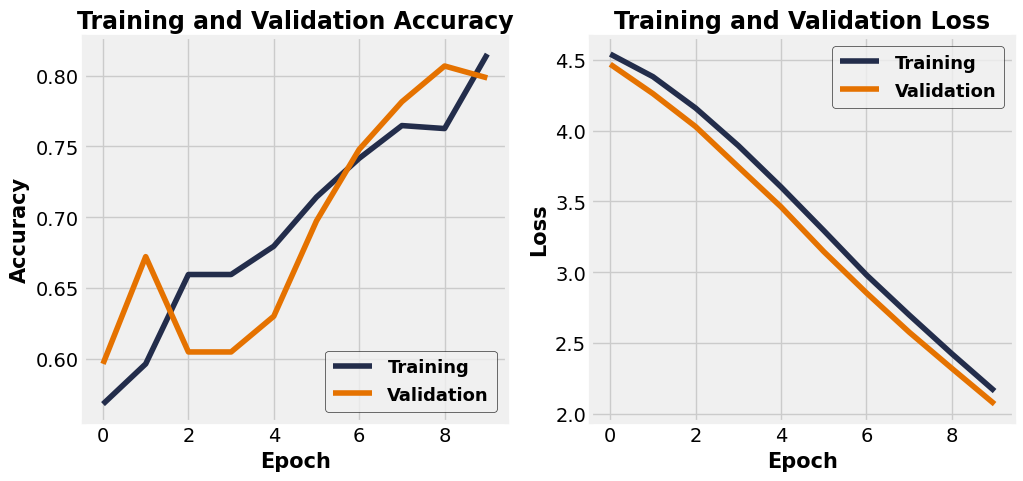

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plot_training_history(acc, val_acc, loss, val_loss, epochs_range)

In [ ]:
# Predict probs for positive class
y_pred_prob = model.predict(X_test)

# AUC-ROC score
auc_roc = roc_auc_score(y_test, y_pred_prob)

# Convert probs to class labels
y_pred_class = (y_pred_prob > 0.5).astype(int)

# F1-score
f1 = f1_score(y_test, y_pred_class)

print("AUC-ROC Score:", auc_roc)
print("F1-Score:", f1)

4/4 [==============================] - 0s 2ms/step
AUC-ROC Score: 0.8670454545454546
F1-Score: 0.761904761904762


---

# Gated RNN (LSTM)

In [ ]:
# Reshape input_shape to add a timestep dimension
input_shape_with_timesteps = (1, input_shape[0])

# Define the neural network model
model2 = Sequential([
    Input(shape=input_shape),
    tf.keras.layers.Reshape(input_shape_with_timesteps),
    LSTM(128,
         activation='tanh',
         kernel_initializer='glorot_uniform',
         recurrent_initializer='orthogonal',
         dropout=0.1,
         recurrent_dropout=0.1),
    Dense(64,
          activation='relu',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(1,
          activation='sigmoid',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01))
])

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model2.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history2 = model2.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/10
30/30 [==============================] - 3s 16ms/step - loss: 1.7834 - accuracy: 0.6218 - val_loss: 1.5401 - val_accuracy: 0.6891
Epoch 2/10
30/30 [==============================] - 0s 6ms/step - loss: 1.3711 - accuracy: 0.7059 - val_loss: 1.2032 - val_accuracy: 0.7227
Epoch 3/10
30/30 [==============================] - 0s 5ms/step - loss: 1.1044 - accuracy: 0.7248 - val_loss: 0.9877 - val_accuracy: 0.7311
Epoch 4/10
30/30 [==============================] - 0s 5ms/step - loss: 0.8478 - accuracy: 0.8120 - val_loss: 0.7804 - val_accuracy: 0.7815
Epoch 5/10
30/30 [==============================] - 0s 6ms/step - loss: 0.6625 - accuracy: 0.8540 - val_loss: 0.6305 - val_accuracy: 0.8319
Epoch 6/10
30/30 [==============================] - 0s 5ms/step - loss: 0.5243 - accuracy: 0.8918 - val_loss: 0.5016 - val_accuracy: 0.8739
Epoch 7/10
30/30 [==============================] - 0s 5ms/step - loss: 0.4368 - accuracy: 0.9118 - val_loss: 0.4510 - val_accuracy: 0.8739
Epoch 8/10
30/30 [=

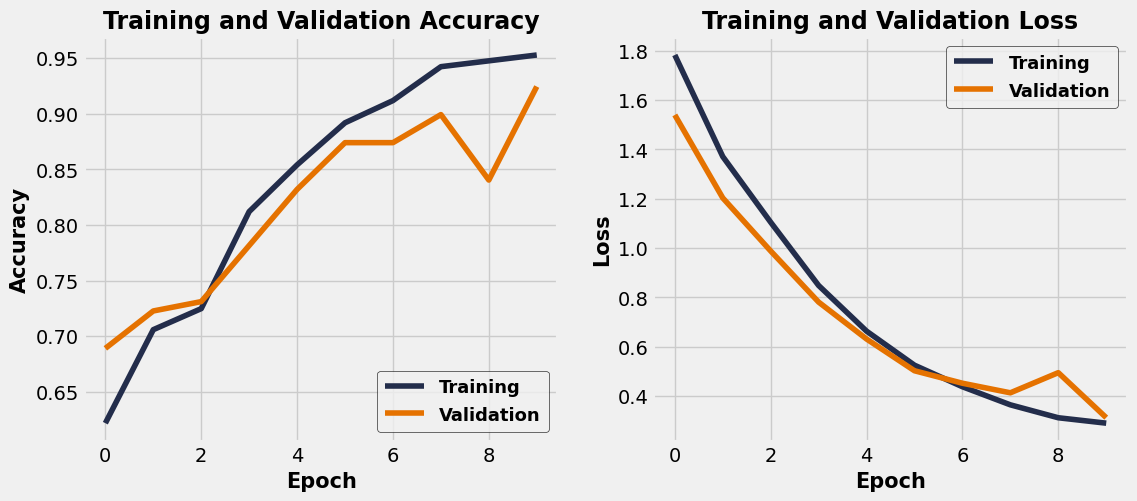

In [ ]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs_range = range(10)

plot_training_history(acc2, val_acc2, loss2, val_loss2, epochs_range)

In [ ]:
# Predict probs for positive class
y_pred_prob2 = model2.predict(X_test)

# AUC-ROC score
auc_roc2 = roc_auc_score(y_test, y_pred_prob2)

# Convert probs to class labels
y_pred_class2 = (y_pred_prob2 > 0.5).astype(int)

# F1-score
f12 = f1_score(y_test, y_pred_class2)

print("AUC-ROC Score:", auc_roc2)
print("F1-Score:", f12)

4/4 [==============================] - 0s 2ms/step
AUC-ROC Score: 0.9556818181818182
F1-Score: 0.9152542372881356


---

# Transformer

## TBD ... for "Next Steps"

In [ ]:
# Convert data into TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffle and batch the datasets
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(buffer_size=len(X_train), seed=28)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.batch(batch_size)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.batch(batch_size)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

class_names = ['0', '1']

---

# Comments on model results:

These results possibly indicate that there are discernible patterns in the text of US presidential speeches that correlate with the US entering a major war  within one year of the speech. This (I think) suggests that Presidents leverage certain language or rhetorical cues in their speeches to prepare the nation for war.

---

# Next Steps:

It would be interesting if we can try to identify discriminative features between the two classes (i.e., Interpretable Learning). So, see if we could answer questions like: What is the model seeing in the speech that makes it classify it as leading up to war or what is missing in the other class that makes it classify that way?

To tackle this we might consider:

### __1__: Layer-wise Relevance Propagation (LRP):

Implement LRP to understand the relevance of input features to the model's predictions. This can help us identify which words or phrases in the speeches contribute most significantly to the classification decision.

### __2__: SHAP (SHapley Additive exPlanations):

Use SHAP values to compute the importance of each feature in the context of individual predictions. This technique will provide insights into how each feature influences the model's output.

### __3__: Feature Importance Scores:

After training our first model, we could extract the weights of the first layer (Dense(128)) and analyze which input features have the highest weights. This can give us an idea of which words or phrases are most influential in determining the classification.

### __4__: Attention Mechanisms:

We can incorporate attention mechanisms into the second model architecture. Attention mechanisms can highlight which parts of the input sequence are most relevant for making predictions, providing interpretability at the token level.

### __5__: Word Embedding Visualization:

Visualize word embeddings to understand how words are represented in the model's embedding space. This can help us identify clusters of words associated with specific classes (e.g., words related to war).

### __6__: Grad-CAM (Gradient-weighted Class Activation Mapping):

If we use a model architecture with convolutional layers, we might consider apply Grad-CAM to visualize which parts of the input text are most important for the model's predictions. This technique highlights regions of the input that contribute most to the final decision.

---

Since we use an LSTM model, attention mechanisms may be useful in understanding which parts of the input sequences are most relevant for classification.

Here's how we can implement attention mechanisms with our LSTM model:

Define an Attention Layer: Define a custom attention layer that calculates attention weights based on the LSTM output.

Modify the Model: Modify the existing model to incorporate the attention layer.

Analyze Attention Weights: Analyze the attention weights to understand which parts of the input sequences are important for classification.

In [ ]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = tf.matmul(x, self.W) + self.b
        at = tf.nn.softmax(et, axis=1)
        output = x * at
        return tf.reduce_sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [ ]:
# Modify model2 to include attention layer
model3 = Sequential([
    Input(shape=input_shape),
    tf.keras.layers.Reshape(input_shape_with_timesteps),
    LSTM(128,
         activation='tanh',
         kernel_initializer='glorot_uniform',
         recurrent_initializer='orthogonal',
         dropout=0.1,
         recurrent_dropout=0.1,
         return_sequences=True),
    AttentionLayer(),  # Add attention layer
    Dense(64,
          activation='relu',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(1,
          activation='sigmoid',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01))
])

In [ ]:
# Compile and train the model as before
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model3.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history3 = model3.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/10
30/30 [==============================] - 3s 19ms/step - loss: 1.7817 - accuracy: 0.6187 - val_loss: 1.5286 - val_accuracy: 0.6723
Epoch 2/10
30/30 [==============================] - 0s 6ms/step - loss: 1.3652 - accuracy: 0.7111 - val_loss: 1.1988 - val_accuracy: 0.7143
Epoch 3/10
30/30 [==============================] - 0s 6ms/step - loss: 1.0519 - accuracy: 0.7952 - val_loss: 0.9483 - val_accuracy: 0.7563
Epoch 4/10
30/30 [==============================] - 0s 6ms/step - loss: 0.8298 - accuracy: 0.8225 - val_loss: 0.7843 - val_accuracy: 0.7983
Epoch 5/10
30/30 [==============================] - 0s 6ms/step - loss: 0.6681 - accuracy: 0.8613 - val_loss: 0.5976 - val_accuracy: 0.8739
Epoch 6/10
30/30 [==============================] - 0s 6ms/step - loss: 0.5446 - accuracy: 0.8897 - val_loss: 0.5107 - val_accuracy: 0.9160
Epoch 7/10
30/30 [==============================] - 0s 6ms/step - loss: 0.4757 - accuracy: 0.8992 - val_loss: 0.4835 - val_accuracy: 0.8655
Epoch 8/10
30/30 [=

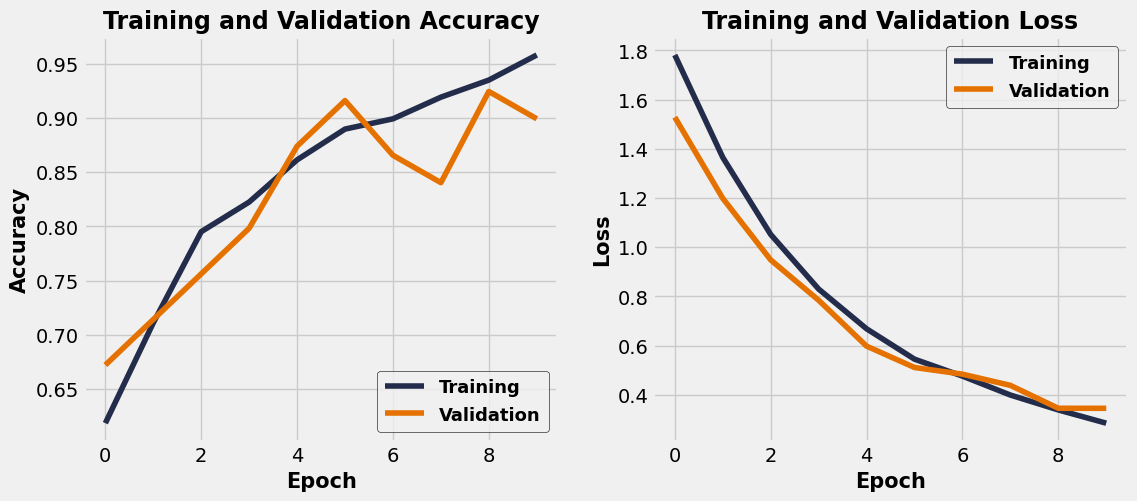

In [ ]:
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']

loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

epochs_range = range(10)

plot_training_history(acc3, val_acc3, loss3, val_loss3, epochs_range)

In [ ]:
# Predict probs for positive class
y_pred_prob3 = model3.predict(X_test)

# AUC-ROC score
auc_roc3 = roc_auc_score(y_test, y_pred_prob3)

# Convert probs to class labels
y_pred_class3 = (y_pred_prob3 > 0.5).astype(int)

# F1-score
f13 = f1_score(y_test, y_pred_class3)

print("AUC-ROC Score:", auc_roc3)
print("F1-Score:", f13)

4/4 [==============================] - 0s 3ms/step
AUC-ROC Score: 0.9446022727272727
F1-Score: 0.8852459016393442


After defining `model3`, we create another model, `attention_model`, using the Model class, specifying the same inputs as model3 but setting the output to that of the attention layer. This allows us to extract the attention weights, providing insights into how the attention mechanism is weighting different parts of the input sequence.

In [ ]:
# Analyze Attention Weights
attention_model = Model(inputs=model3.input, outputs=model3.layers[4].output)
attention_weights = attention_model.predict(X_train)

30/30 [==============================] - 0s 2ms/step


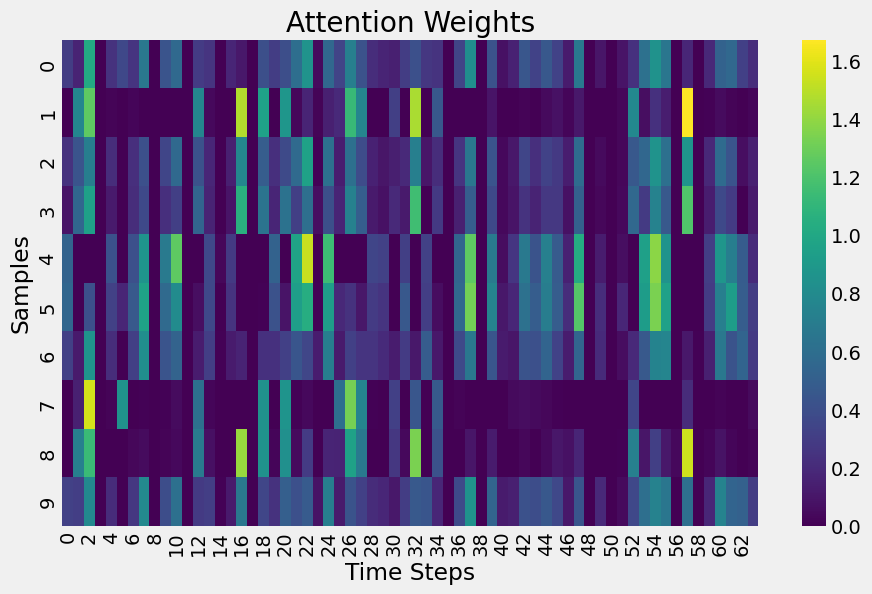

In [ ]:
# Visualize Attention Weights
plt.figure(figsize=(10, 6))
plt.style.use('fivethirtyeight')
sns.heatmap(attention_weights[:10], cmap='viridis')
plt.title('Attention Weights')
plt.xlabel('Time Steps')
plt.ylabel('Samples')
plt.show()

In [ ]:
# Calculate summary statistics of attention weights for each class
mean_attention_wt_class_0 = np.mean(attention_weights[y_train == 0], axis=1)
mean_attention_wt_class_1 = np.mean(attention_weights[y_train == 1], axis=1)

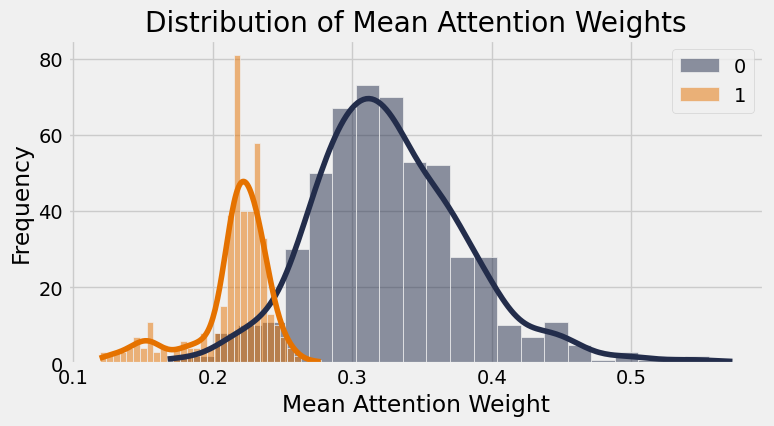

In [ ]:
plt.figure(figsize=(8, 4))
plt.style.use('fivethirtyeight')
sns.histplot(mean_attention_wt_class_0, color='#232D4B', label='0', kde=True)
sns.histplot(mean_attention_wt_class_1, color='#E57200', label='1', kde=True)
plt.title('Distribution of Mean Attention Weights')
plt.xlabel('Mean Attention Weight')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# Perform statistical tests to compare attention weights between classes
t_stat, p_value = ttest_ind(mean_attention_wt_class_0, mean_attention_wt_class_1)
print(f"T-Statistic: {t_stat}, p-value: {p_value}")

T-Statistic: 37.69682116881349, p-value: 7.009240312275537e-191


We could use the `cosine_similarity` function from `sklearn.metrics.pairwise` to compute the cosine similarity matrix between pairs of BERT sequence vectors, then visualize the cosine similarity matrix as a heatmap using `seaborn` to identify patterns of similarity between different speeches.

This visualization maybe can help us understand the semantic relationships between different speeches in our dataset. We can further analyze the clusters and outliers identified in the heatmap to gain insights into the semantic content of the speeches.

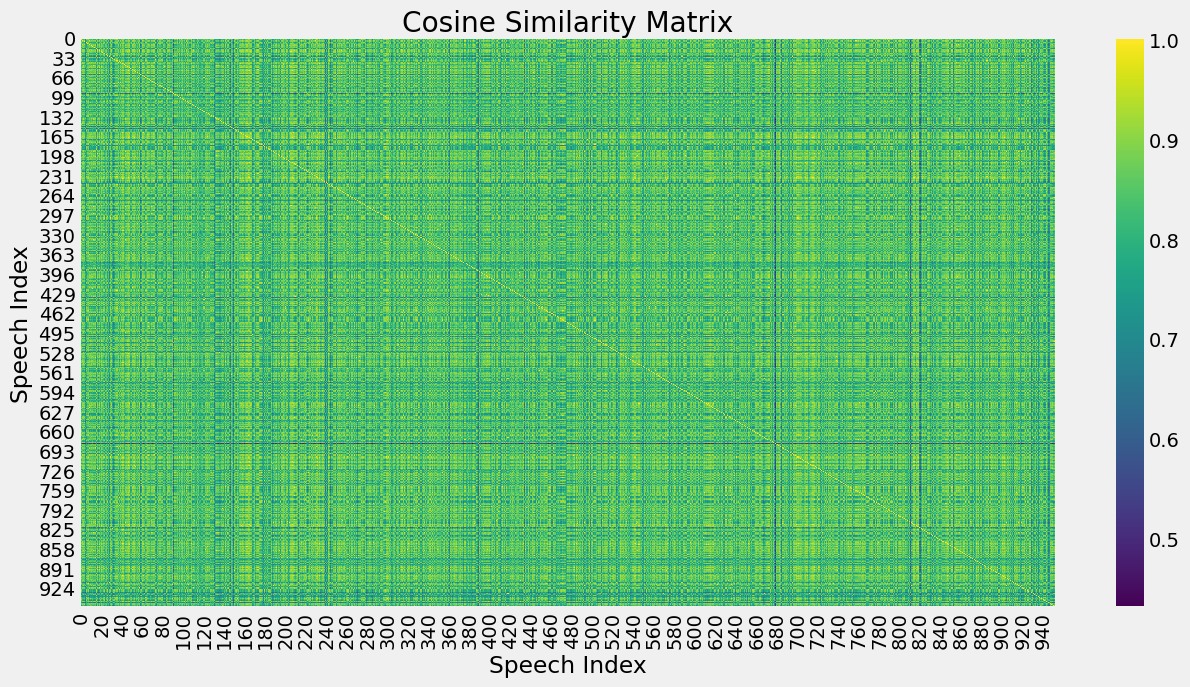

In [ ]:
# Calculate cosine similarity matrix
cos_sim_matrix = cosine_similarity(X_train)

# Visualize similarity matrix as heatmap
plt.figure(figsize=(14, 7))
plt.style.use('fivethirtyeight')
sns.heatmap(cos_sim_matrix, cmap='viridis')
plt.title('Cosine Similarity Matrix')
plt.xlabel('Speech Index')
plt.ylabel('Speech Index')
plt.show()


After computing the cosine similarity matrix and visualizing it as a heatmap, we have some options for further analysis and exploration. Below, we experiment with applying k-means clustering to group similar speeches based on their cosine similarity. This could help identify coherent clusters of speeches with similar semantic content.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


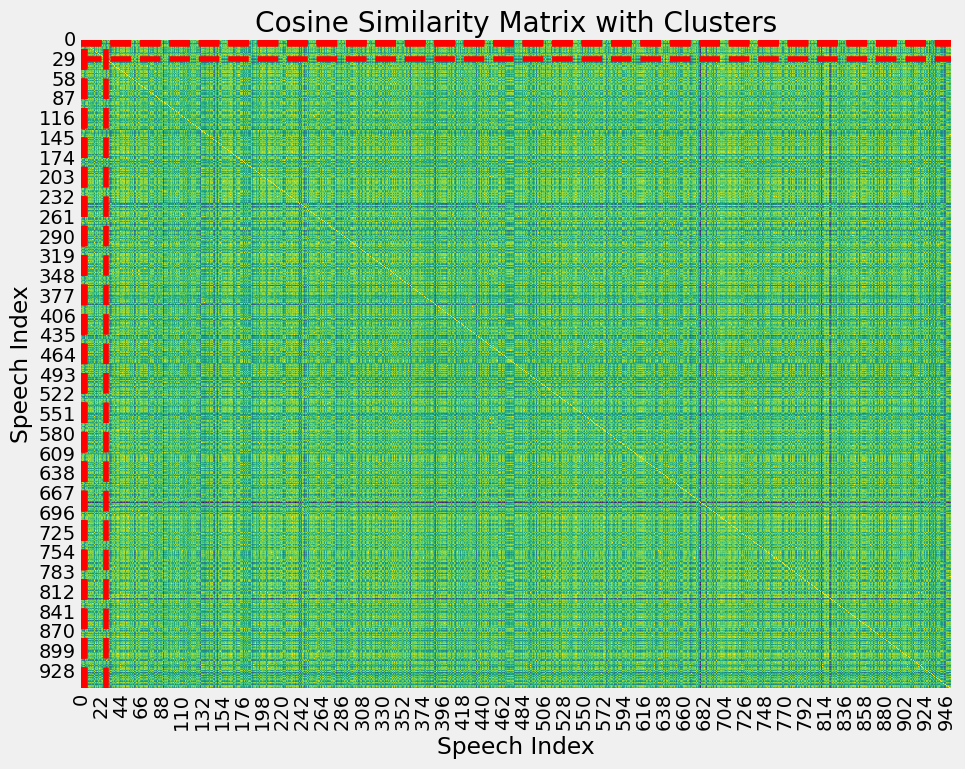

In [ ]:
# Define the number of clusters
num_clusters = 5

# Perform k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(cos_sim_matrix)

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.style.use('fivethirtyeight')
sns.heatmap(cos_sim_matrix, cmap='viridis', cbar=False)
plt.title('Cosine Similarity Matrix with Clusters')
plt.xlabel('Speech Index')
plt.ylabel('Speech Index')

# Draw cluster boundaries
for i in range(num_clusters):
    cluster_indices = np.where(cluster_labels == i)[0]
    plt.axvline(x=min(cluster_indices), color='red', linestyle='--')
    plt.axhline(y=min(cluster_indices), color='red', linestyle='--')

plt.show()

I have no idea how to interpret that plot above ... so perhaps we instead use t-SNE to reduce the dimensionality of the BERT sequence vectors to two dimensions, allowing us to visualize the speeches in a 2D scatter plot?

We plot each speech as a point in the scatter plot, with the color of the point representing its assigned cluster label.

This visualization might provide a more intuitive representation of the clustering results and allow us to observe the spatial distribution of speeches in the reduced-dimensional space.

Each point represents a speech, and points belonging to the same cluster are  grouped together. This visualization could help us understand how the speeches are clustered based on their semantic similarity and identify any discernible patterns or structures.

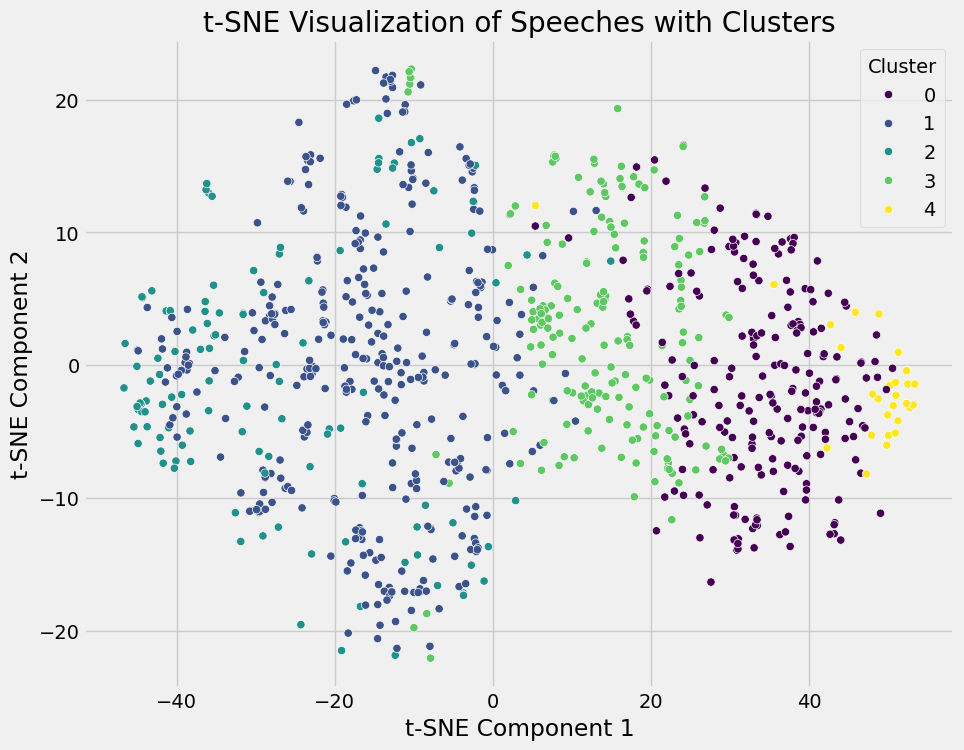

In [ ]:
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
speech_embeddings_2d = tsne.fit_transform(X_train)

# Visualize the speeches in a 2D scatter plot with cluster labels
plt.figure(figsize=(10, 8))
plt.style.use('fivethirtyeight')
sns.scatterplot(x=speech_embeddings_2d[:, 0], y=speech_embeddings_2d[:, 1], hue=cluster_labels, palette='viridis', legend='full')
plt.title('t-SNE Visualization of Speeches with Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()

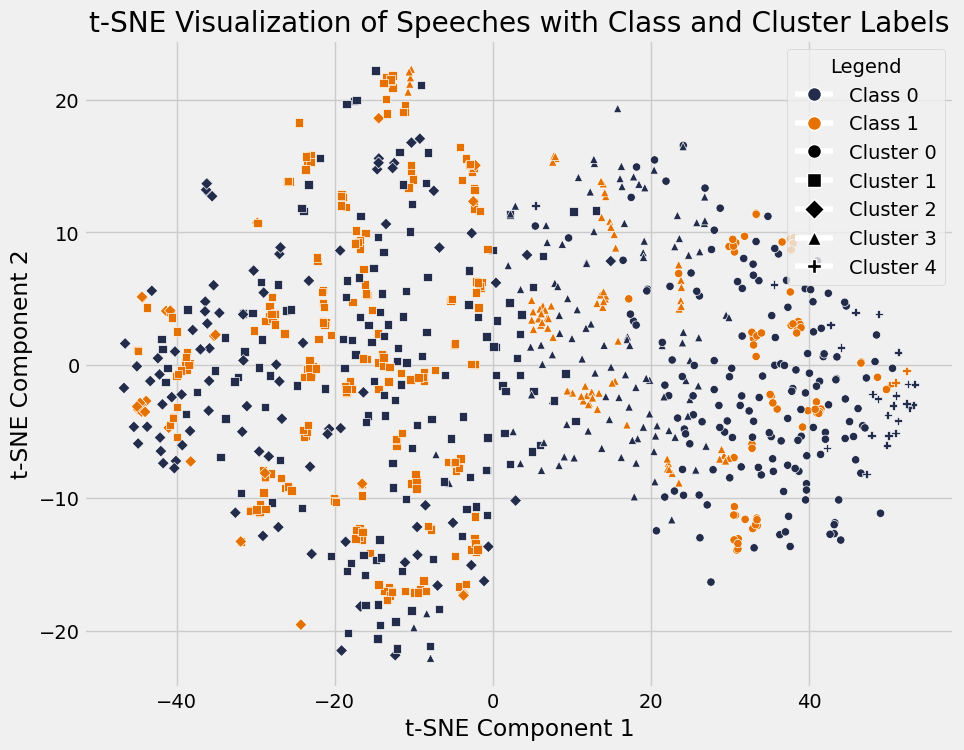

In [ ]:
# Define custom colors for class labels and cluster shapes
class_colors = ['#232D4B', '#E57200']
cluster_shapes = ['o', 's', 'D', '^', 'P']

# Visualize the speeches in a 2D scatter plot with both class and cluster labels
plt.figure(figsize=(10, 8))
plt.style.use('fivethirtyeight')
scatter = sns.scatterplot(x=speech_embeddings_2d[:, 0], y=speech_embeddings_2d[:, 1], hue=y_train, palette=class_colors,
                          style=cluster_labels, markers=cluster_shapes, legend=None)

# Create custom legend
class_legend = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color, label=f'Class {i}')
                for i, color in enumerate(class_colors)]
cluster_legend = [plt.Line2D([0], [0], marker=shape, color='w', markersize=10, markerfacecolor='black', label=f'Cluster {i}')
                  for i, shape in enumerate(cluster_shapes)]

plt.legend(handles=class_legend + cluster_legend, loc='upper right', title='Legend')

plt.title('t-SNE Visualization of Speeches with Class and Cluster Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

Maybe we can experimen with 3D visualization?

In [ ]:
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=3, random_state=42)
speech_embeddings_3d = tsne.fit_transform(X_train)

In [ ]:
# Define class labels and colors
class_labels = ['War = 0', 'War = 1']
class_colors = ['#232D4B', '#E57200']

# Create trace for scatter plot
scatter_trace = go.Scatter3d(
    x=speech_embeddings_3d[:, 0],
    y=speech_embeddings_3d[:, 1],
    z=speech_embeddings_3d[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=y_train,
        colorscale=['#232D4B', '#E57200'],
        opacity=0.8
    ),
    text=y_train,  # Use class labels as hover text
    hoverinfo='text'
)

# Create layout for the plot
layout = go.Layout(
    title='t-SNE Visualization of Speeches with Class Labels',
    scene=dict(
        xaxis=dict(title='t-SNE 1'),
        yaxis=dict(title='t-SNE 2'),
        zaxis=dict(title='t-SNE 3')
    ),
    margin=dict(l=0, r=0, b=0, t=40),
)

# Add annotations for legend
annotations = []
for i, label in enumerate(class_labels):
    annotation = dict(
        x=0.2,
        y=0.9 - i * 0.1,
        xref='paper',
        yref='paper',
        text=label,
        showarrow=False,
        font=dict(color=class_colors[i], size=15),
    )
    annotations.append(annotation)

layout['annotations'] = annotations

# Combine trace and layout to create figure
fig = go.Figure(data=[scatter_trace], layout=layout)

# Display the plot
fig.show()

Not positive how to interpret this chart either, but maybe interesting? The classes appear not to have any clear clustering (they're scattered).

After clustering the speeches, we could analyze the characteristics of each cluster to gain insights into the semantic content represented by each group. For example, we could compute the centroid of each cluster, which represents the "average" speech within the cluster in the reduced-dimensional space.

Then we could examine the speeches closest to each cluster centroid to understand the common themes or topics represented by the cluster.

Finally, we could visualize the distribution of speeches within each cluster to identify any patterns or trends.

In [ ]:
df = pd.read_csv('Speeches_War_Clean.csv')

In [ ]:
# Calculate cluster centroids
cluster_centroids = []
for i in range(num_clusters):
    cluster_indices = np.where(cluster_labels == i)[0]
    cluster_centroid = np.mean(speech_embeddings_3d[cluster_indices], axis=0)
    cluster_centroids.append(cluster_centroid)

# Analyze cluster characteristics
for i, centroid in enumerate(cluster_centroids):
    cluster_indices = np.where(cluster_labels == i)[0]
    distances = cdist([centroid], speech_embeddings_3d[cluster_indices], 'euclidean')[0]
    closest_indices = cluster_indices[np.argsort(distances)[:5]]  # Get indices of 5 closest speeches to centroid
    print(f"Cluster {i} Characteristics:")
    for idx in closest_indices:
        print(f"- Speech {idx}: {df.iloc[idx]['Transcript'][:100]}...")  # Print first 100 characters of speech
    print("\n")

Cluster 0 Characteristics:
- Speech 815: thank you all for that welcome back thank you very very much good afternoon everybody and thank you ...
- Speech 929: mr speaker mr vice president members of congress fellow citizens fiftyone years ago john f kennedy d...
- Speech 602: good evening my fellow citizens i speak to you tonight in a spirit of hope eighteen years ago the ad...
- Speech 460: in april 1928 as a result of discussions between our secretary of state of the united states and the...
- Speech 466: â the departments of commerce and labor are engaged in the usual monthly survey of business and unem...


Cluster 1 Characteristics:
- Speech 886: thank you very much and tonight i have the high privilege and distinct honor of my own as the first ...
- Speech 889: thank you all deputy secretary england thanks for the introduction one boss may not be here but the ...
- Speech 949: mr secretary general mr president world leaders and distinguished delegates welcome to new york it i...


Interesting? But what about the outliers?

Outliers are speeches that are significantly dissimilar to other speeches within their respective clusters. Evaluating outliers can provide insights into unique or distinct topics present in the dataset. We can compute outlier scores for each speech based on its distance from the centroid of its cluster or using other outlier detection techniques. Then, we can examine the transcripts of identified outliers to understand their unique characteristics or topics.

In [ ]:
# Evaluate outliers
for i, centroid in enumerate(cluster_centroids):
    cluster_indices = np.where(cluster_labels == i)[0]
    distances = cdist([centroid], speech_embeddings_3d[cluster_indices], 'euclidean')[0]
    outlier_indices = cluster_indices[np.argsort(distances)[-5:]]  # Get indices of 5 farthest speeches from centroid
    print(f"Cluster {i} Outliers:")
    for idx in outlier_indices:
        print(f"- Speech {idx}: {df.iloc[idx]['Transcript'][:100]}...")  # Print first 100 characters of speech
    print("\n")

Cluster 0 Outliers:
- Speech 584: president odegaard members othe regents members of the faculty students ladies and gentlemen it is a...
- Speech 93: fellow citizens of the senate and house of representatives the act of the 23d of june 1836 regulatin...
- Speech 268: with devout gratitude to the bountiful giver of all good i congratulate you that at the beginning of...
- Speech 606: mr speaker mr president members of the house members of the senate my fellow americans all i have i ...
- Speech 377: to the senate in response to senate resolution of december addressed to me and to the two senate res...


Cluster 1 Outliers:
- Speech 429: chairman lodge members of the notification committee members of the national committee ladies and ge...
- Speech 590: general westmoreland general lemnitzer mr secretary general decker general taylor members of the gra...
- Speech 487: i want to talk for a few minutes with the people of the united states about banking with the compara...
- Speech 354: t

---

## SHAP

TBD ...

In [ ]:
# # Create a DeepExplainer instance
# explainer = shap.Explainer(model, X_train)

# # Compute SHAP values
# shap_values = explainer.shap_values(X_train)

In [ ]:
# # Plot SHAP summary plot
# shap.summary_plot(shap_values, X, plot_type="bar", show=False)
# plt.title('SHAP Feature Importance')
# plt.show()

# # Alternatively, you can plot a force plot for a single prediction
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[0], X.iloc[0, :], show=True)